# Crime Analyzer — General — Visualization & Exploratory Analysis (Final)

Purpose
- Provide a reproducible, publication-quality visualization pass on the engineered NYC crime dataset
- Highlight non-obvious insights: distribution inequality (Gini), Pareto effects, spatio-temporal peaks, and geographic hotspots

Inputs
- File: JupyterOutputs/Final/final_crime_data.csv (produced by the Final Data notebook)

Outputs (written to JupyterOutputs/VisualizationPreprocessing)
- crime_types_pie_chart.png, crime_types_bar_chart.png
- crime_by_hour.png, crime_heatmap_day_hour.png
- crime_heatmap.html, enhanced_crime_heatmap.html (interactive)

Notes
- Figures are styled for reports; interactive maps are saved to HTML files
- Visuals auto-adapt to available columns (OFNS_DESC, WEEKDAY, HOUR, MONTH, YEAR, Latitude/Longitude)
- Code uses safe fallbacks and avoids hard failures when columns are missing

## Imports and data loading

This section loads plotting libraries and reads the final dataset. It also prints a compact data quality summary to inform the rest of the analysis.

In [36]:
import os
import sys
import warnings
from pathlib import Path
from typing import Optional, Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from folium.plugins import HeatMap
import folium
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# Paths
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
vis_dir = os.path.join(base_dir, "VisualizationPreprocessing")
os.makedirs(vis_dir, exist_ok=True)


def load_and_validate_data(file_path: str) -> Optional[pd.DataFrame]:
    """
    Load crime dataset with comprehensive validation and error handling.
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found: {file_path}")

        # Load dataset with optimized dtypes
        print(f"Loading dataset from: {file_path}")
        df = pd.read_csv(file_path, low_memory=False)

        # Basic validation
        if df.empty:
            raise ValueError("Loaded dataset is empty")

        print(f"Dataset loaded successfully: {len(df):,} rows and {len(df.columns)} columns")

        # Data quality summary
        print(f"\n=== Data Quality Summary ===")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"Missing values: {df.isnull().sum().sum():,} ({df.isnull().sum().sum()/df.size*100:.2f}%)")
        print(f"Duplicate rows: {df.duplicated().sum():,}")

        return df

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load dataset
file_path = os.path.join(base_dir, "Final", "final_crime_data.csv")
df = load_and_validate_data(file_path)

Loading dataset from: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv
Dataset loaded successfully: 2,493,835 rows and 44 columns

=== Data Quality Summary ===
Dataset loaded successfully: 2,493,835 rows and 44 columns

=== Data Quality Summary ===
Memory usage: 2719.72 MB
Memory usage: 2719.72 MB
Missing values: 0 (0.00%)
Missing values: 0 (0.00%)
Duplicate rows: 0
Duplicate rows: 0


## Crime type distribution (with inequality metrics)

We summarize offense categories and quantify inequality using the Gini coefficient. This helps detect dominance of a few categories and supports prioritization (Pareto).

In [38]:
def calculate_gini_coefficient(series: pd.Series) -> float:
    """
    Calculate Gini coefficient for measuring inequality in distribution.
    """
    values = np.array(series.values, dtype=float)
    values = values[values >= 0]
    if values.size == 0 or values.sum() == 0:
        return 0.0
    sorted_values = np.sort(values)
    n = len(sorted_values)
    cumvals = np.cumsum(sorted_values)
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n


def create_enhanced_pie_chart(df: pd.DataFrame, column: str = 'OFNS_DESC',
                             top_n: int = 8, figsize: tuple = (12, 10)) -> Optional[str]:
    """
    Create an enhanced pie chart with statistical annotations and improved aesthetics.
    Returns saved filepath or None.
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in dataset")
        return None

    plt.figure(figsize=figsize)

    # Calculate distribution statistics
    crime_counts = df[column].value_counts(dropna=False)
    total_crimes = len(df)

    # Prepare data for pie chart
    top_crimes = crime_counts.head(top_n)
    other_crimes = pd.Series([crime_counts[top_n:].sum()], index=['Other'])
    crime_pie_data = pd.concat([top_crimes, other_crimes])

    # Create enhanced pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(crime_pie_data)))
    explode = [0.08] + [0] * (len(crime_pie_data) - 1)

    wedges, texts, autotexts = plt.pie(
        crime_pie_data,
        labels=crime_pie_data.index.astype(str),
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_crimes):,})',
        shadow=True,
        startangle=90,
        explode=explode,
        textprops={'fontsize': 10, 'fontweight': 'bold'},
        colors=colors
    )

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.title('Distribution of Crime Types\n(Enhanced Statistical Analysis)',
              fontsize=16, fontweight='bold', pad=20)

    # Add statistical summary
    gini_coeff = calculate_gini_coefficient(crime_counts)
    plt.figtext(0.02, 0.02, f'Gini Coefficient: {gini_coeff:.3f}\nTotal Crimes: {total_crimes:,}\nUnique Categories: {len(crime_counts)}',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.axis('equal')
    plt.tight_layout()

    # Save to file to avoid duplicate rendering in batch
    out_path = os.path.join(vis_dir, 'crime_types_pie_chart.png')
    plt.savefig(out_path)
    plt.close()
    print(f"Pie chart saved to: {out_path}")

    # Print detailed statistics
    percentages = (crime_pie_data / total_crimes * 100).round(1)
    print(f"\n=== Crime Type Distribution Statistics ===")
    print(f"Top {top_n} categories represent {percentages.head(top_n).sum():.1f}% of all crimes")
    print(f"Most frequent: {crime_counts.index[0]} ({crime_counts.iloc[0]:,} cases, {percentages.iloc[0]:.1f}%)")
    print(f"Distribution inequality (Gini): {gini_coeff:.3f}")
    return out_path


def create_enhanced_barplot(df: pd.DataFrame, column: str = 'OFNS_DESC',
                           top_n: int = 15, figsize: tuple = (14, 10)) -> Optional[str]:
    """
    Create an enhanced bar plot with statistical annotations.
    Returns saved filepath or None.
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in dataset")
        return None

    plt.figure(figsize=figsize)

    # Calculate statistics
    top_crimes = df[column].value_counts().head(top_n)
    total_crimes = len(df)
    percentages = (top_crimes / total_crimes * 100).round(2)

    # Create enhanced bar plot
    ax = sns.barplot(x=top_crimes.values, y=top_crimes.index,
                     palette='viridis', orient='h')

    # Add value annotations
    for i, (value, percentage) in enumerate(zip(top_crimes.values, percentages.values)):
        ax.text(value + max(top_crimes.values) * 0.01, i,
                f'{value:,} ({percentage:.1f}%)',
                va='center', fontweight='bold')

    plt.title(f'Top {top_n} Crime Categories\n(Statistical Analysis)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Events (with percentages)', fontweight='bold')
    plt.ylabel('Crime Category', fontweight='bold')

    # Add statistical summary
    cumulative_pct = percentages.cumsum()
    pareto_80_index = (cumulative_pct <= 80).sum()

    if pareto_80_index > 0:
        pareto_text = (
            f'Pareto Analysis: Top {pareto_80_index} categories = '
            f'{cumulative_pct.iloc[pareto_80_index-1]:.1f}% of crimes\n'
            f'Top {top_n} represent {percentages.sum():.1f}% of all crimes'
        )
    else:
        pareto_text = f'Top {top_n} represent {percentages.sum():.1f}% of all crimes'

    plt.figtext(0.02, 0.02, pareto_text,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()

    out_path = os.path.join(vis_dir, 'crime_types_bar_chart.png')
    plt.savefig(out_path)
    plt.close()
    print(f"Bar chart saved to: {out_path}")

    # Print Pareto analysis
    print(f"\n=== Pareto Analysis ===")
    print(f"Top {pareto_80_index} categories account for ~80% of crimes")
    for i in range(min(5, len(top_crimes))):
        print(f"{i+1}. {top_crimes.index[i]}: {top_crimes.iloc[i]:,} ({percentages.iloc[i]:.1f}%)")
    return out_path

# Create enhanced charts
if df is not None and 'OFNS_DESC' in df.columns:
    create_enhanced_pie_chart(df, 'OFNS_DESC')
    create_enhanced_barplot(df, 'OFNS_DESC')
else:
    print("OFNS_DESC column not found - skipping pie/bar chart visualization")

Pie chart saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\VisualizationPreprocessing\crime_types_pie_chart.png

=== Crime Type Distribution Statistics ===
Top 8 categories represent 75.6% of all crimes
Most frequent: PETIT LARCENY (497,101 cases, 19.9%)
Distribution inequality (Gini): 0.843
Bar chart saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\VisualizationPreprocessing\crime_types_bar_chart.png

=== Pareto Analysis ===
Top 9 categories account for ~80% of crimes
1. PETIT LARCENY: 497,101 (19.9%)
2. HARRASSMENT 2: 392,133 (15.7%)
3. ASSAULT 3 & RELATED OFFENSES: 264,946 (10.6%)
4. GRAND LARCENY: 224,899 (9.0%)
5. CRIMINAL MISCHIEF & RELATED OF: 215,756 (8.7%)
Bar chart saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\VisualizationPreprocessing\crime_types_bar_chart.png

=== Pareto Analysis ===
Top 9 categories account for ~80% of crimes
1. PETIT LARCENY: 497,101 (19.9%)
2. HARRASSMENT 2: 392,133 (15.7%)
3. ASSAU

### Top categories bar plot
We highlight the most frequent categories, annotate absolute counts and percentages, and compute how many categories explain ~80% of crimes.

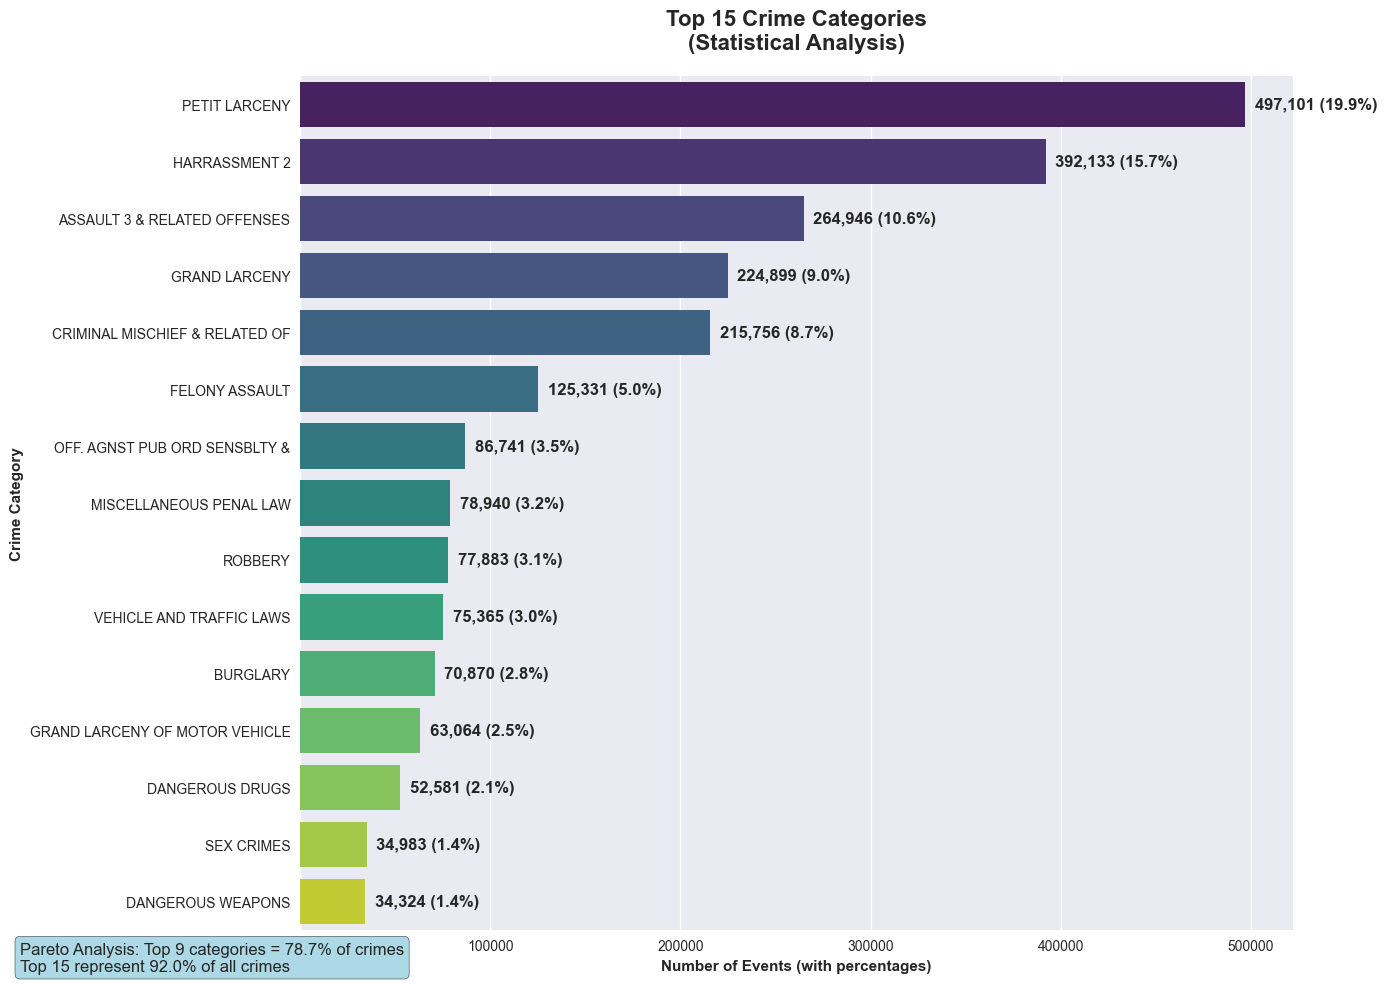


=== Pareto Analysis ===
Top 9 categories account for ~80% of crimes
1. PETIT LARCENY: 497,101 (19.9%)
2. HARRASSMENT 2: 392,133 (15.7%)
3. ASSAULT 3 & RELATED OFFENSES: 264,946 (10.6%)
4. GRAND LARCENY: 224,899 (9.0%)
5. CRIMINAL MISCHIEF & RELATED OF: 215,756 (8.7%)


In [39]:
def create_enhanced_barplot(df: pd.DataFrame, column: str = 'OFNS_DESC',
                           top_n: int = 15, figsize: tuple = (14, 10)) -> None:
    """
    Create an enhanced bar plot with statistical annotations.
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in dataset")
        return

    plt.figure(figsize=figsize)

    # Calculate statistics
    top_crimes = df[column].value_counts().head(top_n)
    total_crimes = len(df)
    percentages = (top_crimes / total_crimes * 100).round(2)

    # Create enhanced bar plot
    ax = sns.barplot(x=top_crimes.values, y=top_crimes.index,
                     palette='viridis', orient='h')

    # Add value annotations
    for i, (value, percentage) in enumerate(zip(top_crimes.values, percentages.values)):
        ax.text(value + max(top_crimes.values) * 0.01, i,
                f'{value:,} ({percentage:.1f}%)',
                va='center', fontweight='bold')

    plt.title(f'Top {top_n} Crime Categories\n(Statistical Analysis)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Events (with percentages)', fontweight='bold')
    plt.ylabel('Crime Category', fontweight='bold')

    # Add statistical summary
    cumulative_pct = percentages.cumsum()
    pareto_80_index = (cumulative_pct <= 80).sum()

    plt.figtext(0.02, 0.02,
                f'Pareto Analysis: Top {pareto_80_index} categories = {cumulative_pct.iloc[pareto_80_index-1]:.1f}% of crimes\n'
                f'Top {top_n} represent {percentages.sum():.1f}% of all crimes',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.show()

    # Print Pareto analysis
    print(f"\n=== Pareto Analysis ===")
    print(f"Top {pareto_80_index} categories account for ~80% of crimes")
    for i in range(min(5, len(top_crimes))):
        print(f"{i+1}. {top_crimes.index[i]}: {top_crimes.iloc[i]:,} ({percentages.iloc[i]:.1f}%)")

# Create enhanced bar plot
if 'OFNS_DESC' in df.columns:
    create_enhanced_barplot(df, 'OFNS_DESC')
else:
    print("OFNS_DESC column not found - skipping bar plot visualization")

### Spatio-temporal pattern heatmap (day × hour)

We quantify whether crime timing is non-random using a chi-square test on the day-hour contingency table, and annotate peak cells. This supports staffing and patrol scheduling decisions.

In [40]:
# Enhanced Temporal Heatmap with Statistical Analysis


def create_enhanced_temporal_heatmap(df: pd.DataFrame, figsize: tuple = (16, 10)) -> None:
    """
    Create an enhanced temporal heatmap with statistical analysis.
    """
    # Validate required columns
    required_cols = ['WEEKDAY', 'HOUR']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        return

    # Create cross-tabulation
    day_order = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    day_hour_pivot = pd.crosstab(df['WEEKDAY'], df['HOUR'])

    # Reindex to ensure proper day ordering
    available_days = [day for day in day_order if day in day_hour_pivot.index]
    day_hour_pivot = day_hour_pivot.reindex(available_days)

    # Calculate statistics
    total_crimes = day_hour_pivot.sum().sum()
    percentages = (day_hour_pivot / total_crimes * 100).round(2)

    # Statistical analysis
    chi2, p_value, dof, expected = chi2_contingency(day_hour_pivot)

    # Create enhanced heatmap
    plt.figure(figsize=figsize)

    # Create heatmap with annotations
    ax = sns.heatmap(
        day_hour_pivot,
        cmap='YlOrRd',
        annot=False,
        fmt='d',
        cbar_kws={'label': 'Number of Crime Events'},
        linewidths=0.5,
    )

    plt.title(
        'Crime Distribution by Day of Week and Hour\n'
        f'(Statistical Analysis: χ² = {chi2:.2f}, p = {p_value:.2e})',
        fontsize=16,
        fontweight='bold',
        pad=20,
    )
    plt.xlabel('Hour of Day', fontweight='bold')
    plt.ylabel('Day of Week', fontweight='bold')

    # Add statistical annotations for peaks
    max_val = day_hour_pivot.max().max()
    threshold = max_val * 0.8  # Top 20% threshold

    for i in range(len(day_hour_pivot.index)):
        for j in range(len(day_hour_pivot.columns)):
            value = day_hour_pivot.iloc[i, j]
            if value >= threshold:
                plt.text(
                    j + 0.5,
                    i + 0.5,
                    f'{value}\n({percentages.iloc[i, j]:.1f}%)',
                    ha='center',
                    va='center',
                    color='white',
                    fontweight='bold',
                )

    plt.tight_layout()

    # Save figure to batch export folder
    out_path = os.path.join(vis_dir, 'crime_heatmap_day_hour.png')
    plt.savefig(out_path)
    print(f"Enhanced day-hour heatmap saved as: {out_path}")
    plt.close()

    # Statistical summary
    print(f"\n=== Temporal Pattern Analysis ===")
    print(f"Chi-square test: χ² = {chi2:.2f}, p-value = {p_value:.2e}")
    if p_value < 0.05:
        print("Strong evidence of non-random temporal patterns (p < 0.05)")

    # Find peak times
    peak_time = day_hour_pivot.stack().idxmax()
    peak_value = day_hour_pivot.stack().max()
    peak_day, peak_hour = peak_time

    print(f"Peak crime time: {peak_day} at {peak_hour}:00 ({peak_value:,} events)")

    # Day-wise analysis
    daily_totals = day_hour_pivot.sum(axis=1).sort_values(ascending=False)
    print(f"\nBusiest days (total crimes):")
    for day, count in daily_totals.head(3).items():
        print(f"  {day}: {count:,} events")

    # Hour-wise analysis
    hourly_totals = day_hour_pivot.sum(axis=0).sort_values(ascending=False)
    print(f"\nBusiest hours (total crimes):")
    for hour, count in hourly_totals.head(3).items():
        print(f"  {hour}:00: {count:,} events")

### Geographic hotspot mapping (interactive)

We validate coordinates, sample for performance when needed, and render an interactive heatmap. The HTML outputs can be opened without a notebook for deployment-ready sharing.

In [41]:
# Detect geographic columns; mapping emitted in batch section to avoid duplicates
latitude_cols = [col for col in df.columns if 'lat' in col.lower()] if df is not None else []
longitude_cols = [col for col in df.columns if 'lon' in col.lower() and 'lat_lon' not in col.lower()] if df is not None else []

if latitude_cols and longitude_cols:
    print(f"Using geographic columns: {latitude_cols[0]}, {longitude_cols[0]}")
else:
    print("No suitable geographic columns found for mapping")
    if df is not None:
        print(f"Available columns: {df.columns.tolist()}")


def create_enhanced_geographic_heatmap(df: pd.DataFrame,
                                      lat_col: str = 'Latitude',
                                      lon_col: str = 'Longitude',
                                      max_points: int = 10000) -> Optional[folium.Map]:
    """
    Create an enhanced geographic heatmap with statistical analysis.
    Returns the folium.Map instance.
    """
    try:
        # Validate geographic columns
        if lat_col not in df.columns or lon_col not in df.columns:
            print(f"Geographic columns not found: {lat_col}, {lon_col}")
            return None

        # Data validation and cleaning
        print("Performing geographic data validation...")

        # Remove invalid coordinates
        valid_coords = (
            df[lat_col].notnull() &
            df[lon_col].notnull() &
            (df[lat_col] != 0) &
            (df[lon_col] != 0) &
            (df[lat_col].between(40.4, 41.0)) &  # NYC latitude bounds
            (df[lon_col].between(-74.5, -73.7))  # NYC longitude bounds
        )

        clean_df = df[valid_coords].copy()

        if clean_df.empty:
            print("No valid geographic coordinates found")
            return None

        print(f"Valid coordinates: {len(clean_df):,} out of {len(df):,} records ({len(clean_df)/len(df)*100:.1f}%)")

        # Statistical analysis of geographic distribution
        lat_stats = {
            'mean': float(clean_df[lat_col].mean()),
            'std': float(clean_df[lat_col].std()),
            'min': float(clean_df[lat_col].min()),
            'max': float(clean_df[lat_col].max())
        }

        lon_stats = {
            'mean': float(clean_df[lon_col].mean()),
            'std': float(clean_df[lon_col].std()),
            'min': float(clean_df[lon_col].min()),
            'max': float(clean_df[lon_col].max())
        }

        # Sample data if too large for performance
        if len(clean_df) > max_points:
            print(f"Sampling {max_points:,} points for visualization performance...")
            sample_df = clean_df.sample(n=max_points, random_state=42)
        else:
            sample_df = clean_df

        # Create map centered on data
        map_center = [lat_stats['mean'], lon_stats['mean']]
        print(f"Map centered at: {map_center[0]:.4f}, {map_center[1]:.4f}")

        # Create folium map with enhanced styling
        crime_map = folium.Map(
            location=map_center,
            zoom_start=11,
            tiles='CartoDB positron'  # Clean, professional styling
        )

        # Prepare heat data as pure floats to avoid plugin parsing issues
        heat_data = sample_df[[lat_col, lon_col]].astype(float).values.tolist()

        # Add heatmap layer with conservative/default parameters
        HeatMap(
            heat_data,
            radius=8,
            blur=12,
            max_zoom=18
        ).add_to(crime_map)

        # Save map in VisualizationPreprocessing folder
        map_filename = os.path.join(vis_dir, 'enhanced_crime_heatmap.html')
        crime_map.save(map_filename)
        print(f"Enhanced heatmap saved as: {map_filename}")

        # Display in notebook
        display(crime_map)
       
        # Geographic statistics summary
        print(f"\n=== Geographic Distribution Statistics ===")
        print(f"Latitude range: {lat_stats['min']:.4f} to {lat_stats['max']:.4f} (spread: {lat_stats['max']-lat_stats['min']:.4f})")
        print(f"Longitude range: {lon_stats['min']:.4f} to {lon_stats['max']:.4f} (spread: {lon_stats['max']-lon_stats['min']:.4f})")
        print(f"Geographic center: ({lat_stats['mean']:.4f}, {lon_stats['mean']:.4f})")
        print(f"Standard deviations: Lat ±{lat_stats['std']:.4f}, Lon ±{lon_stats['std']:.4f}")

        return crime_map
    except Exception as e:
        print(f"Error creating geographic heatmap: {e}")
        return None

Using geographic columns: Latitude, Longitude


## Comprehensive statistical sweep

This section prints a compact overview for analysts and reviewers:
- Dataset size, memory, date span
- Missing values and potential data risks
- First-pass correlations across numeric features (only when safe to display)
Use this to gauge whether visual conclusions are robust.

In [42]:
def comprehensive_data_analysis(df: pd.DataFrame) -> None:
    """
    Perform comprehensive statistical analysis of the crime dataset.
    """
    print("\n" + "="*60)
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print("="*60)

    # Dataset overview
    print(f"\n1. DATASET OVERVIEW")
    print(f"   Total records: {len(df):,}")
    print(f"   Total features: {len(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Date range: {get_date_range(df)}")

    # Missing data analysis
    print(f"\n2. DATA QUALITY ASSESSMENT")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df) * 100).round(2)

    if missing_data.sum() > 0:
        print("   Columns with missing data:")
        for col, count, pct in zip(missing_data.index, missing_data.values, missing_pct.values):
            if count > 0:
                print(f"     {col}: {count:,} ({pct:.2f}%)")
    else:
        print("   No missing data detected")

    # Categorical variables analysis
    print(f"\n3. CATEGORICAL VARIABLES ANALYSIS")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols[:5]:  # Analyze top 5 categorical columns
        unique_count = df[col].nunique()
        top_category = df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'
        top_freq = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 0
        print(f"   {col}: {unique_count} unique values, top: '{top_category}' ({top_freq:,} occurrences)")

    # Numerical variables analysis
    print(f"\n4. NUMERICAL VARIABLES ANALYSIS")
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print("   Key statistics:")
        for col in numerical_cols[:5]:  # Analyze top 5 numerical columns
            series = df[col].dropna()
            if len(series) > 0:
                print(f"     {col}: mean={series.mean():.2f}, std={series.std():.2f}, range=[{series.min():.2f}, {series.max():.2f}]")

    # Temporal analysis (if available)
    if any(col in df.columns for col in ['HOUR', 'WEEKDAY', 'MONTH']):
        print(f"\n5. TEMPORAL PATTERNS")
        if 'HOUR' in df.columns:
            peak_hour = df['HOUR'].mode().iloc[0] if not df['HOUR'].mode().empty else 'N/A'
            print(f"   Peak crime hour: {peak_hour}:00")
        if 'WEEKDAY' in df.columns:
            peak_day = df['WEEKDAY'].mode().iloc[0] if not df['WEEKDAY'].mode().empty else 'N/A'
            print(f"   Peak crime day: {peak_day}")

    # Geographic analysis (if available)
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    if lat_cols and lon_cols:
        print(f"\n6. GEOGRAPHIC DISTRIBUTION")
        lat_col, lon_col = lat_cols[0], lon_cols[0]
        valid_coords = df[lat_col].notnull() & df[lon_col].notnull()
        coord_coverage = valid_coords.sum() / len(df) * 100
        print(f"   Geographic coverage: {coord_coverage:.1f}% of records have valid coordinates")
        if coord_coverage > 0:
            center_lat = df.loc[valid_coords, lat_col].mean()
            center_lon = df.loc[valid_coords, lon_col].mean()
            print(f"   Geographic center: ({center_lat:.4f}, {center_lon:.4f})")

def get_date_range(df: pd.DataFrame) -> str:
    """
    Extract date range from DataFrame.
    """
    date_cols = [col for col in df.columns if any(x in col.upper() for x in ['DATE', 'YEAR', 'MONTH'])]

    if 'YEAR' in df.columns:
        years = df['YEAR'].dropna()
        if not years.empty:
            return f"{years.min()}-{years.max()}"

    for col in date_cols:
        try:
            dates = pd.to_datetime(df[col], errors='coerce').dropna()
            if not dates.empty:
                return f"{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}"
        except:
            continue

    return "Date range not determinable"

def create_correlation_analysis(df: pd.DataFrame) -> None:
    """
    Create correlation analysis for numerical variables.
    """
    print("\n7. CORRELATION ANALYSIS")

    # Select numerical columns
    numerical_df = df.select_dtypes(include=[np.number])

    if numerical_df.shape[1] < 2:
        print("   Insufficient numerical variables for correlation analysis")
        return

    # Calculate correlation matrix
    corr_matrix = numerical_df.corr()

    # Find strong correlations (|r| > 0.5)
    strong_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

    if strong_corr:
        print("   Strong correlations found (|r| > 0.5):")
        for var1, var2, corr_val in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True)[:5]:
            print(f"     {var1} ↔ {var2}: r = {corr_val:.3f}")
    else:
        print("   No strong correlations found (all |r| ≤ 0.5)")

    # Create correlation heatmap if reasonable number of variables
    if 3 <= numerical_df.shape[1] <= 15:
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': .8})
        plt.title('Correlation Matrix (Numerical Variables)', fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"   Correlation matrix not displayed ({numerical_df.shape[1]} variables)")

# Execute comprehensive analysis
comprehensive_data_analysis(df)
create_correlation_analysis(df)

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


COMPREHENSIVE STATISTICAL ANALYSIS

1. DATASET OVERVIEW
   Total records: 2,493,835
   Total features: 44
   Memory usage: 2719.72 MB
   Date range: 2020-2024

2. DATA QUALITY ASSESSMENT
   Memory usage: 2719.72 MB
   Date range: 2020-2024

2. DATA QUALITY ASSESSMENT
   No missing data detected

3. CATEGORICAL VARIABLES ANALYSIS
   No missing data detected

3. CATEGORICAL VARIABLES ANALYSIS
   BORO_NM: 5 unique values, top: 'BROOKLYN' (698,859 occurrences)
   BORO_NM: 5 unique values, top: 'BROOKLYN' (698,859 occurrences)
   LAW_CAT_CD: 3 unique values, top: 'MISDEMEANOR' (1,269,123 occurrences)
   LAW_CAT_CD: 3 unique values, top: 'MISDEMEANOR' (1,269,123 occurrences)
   LOC_OF_OCCUR_DESC: 5 unique values, top: 'INSIDE' (1,360,666 occurrences)
   LOC_OF_OCCUR_DESC: 5 unique values, top: 'INSIDE' (1,360,666 occurrences)
   OFNS_DESC: 71 unique values, top: 'PETIT LARCENY' (497,101 occurrences)
   OFNS_DESC: 71 unique values, top: 'PETIT LARCENY' (497,101 occurrences)
   PREM_TYP_DESC:

## Batch export of significant plots

This section renders and saves the most informative visuals for reports and dashboards. All files are written to JupyterOutputs/VisualizationPreprocessing for easy sharing and deployment.

In [43]:
# 2.1 Time of Day Analysis (if HOUR column exists)
if df is not None and 'HOUR' in df.columns:
    print("Creating time of day analysis using HOUR column")
    plt.figure(figsize=(14, 8))
    hour_counts = df['HOUR'].value_counts().sort_index()
    sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="viridis")
    plt.title('Crime Incidents by Hour of Day', fontsize=16)
    plt.xlabel('Hour (24-hour format)')
    plt.ylabel('Number of Incidents')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    hour_path = os.path.join(vis_dir, 'crime_by_hour.png')
    plt.savefig(hour_path)
    plt.close()
    print(f"Hour of day bar chart saved as: {hour_path}")

# 2.1b Enhanced Day x Hour Heatmap (only once, using enhanced function)
if df is not None and 'WEEKDAY' in df.columns and 'HOUR' in df.columns:
    print("Creating enhanced crime heatmap by day and hour...")
    create_enhanced_temporal_heatmap(df)

# 2.2 Geographic visualization using separate Latitude and Longitude columns
if latitude_cols and longitude_cols and df is not None:
    try:
        lat_col = latitude_cols[0]
        lon_col = longitude_cols[0]
        print(f"Creating geographic visualization using columns: {lat_col} and {lon_col}...")

        valid_coords = (df[lat_col].notnull() &
                        df[lon_col].notnull() &
                        (df[lat_col] != 0) &
                        (df[lon_col] != 0))
        geo_df = df[valid_coords]
        print(f"Using {len(geo_df)} valid geographic coordinates for visualization")

        if len(geo_df) == 0:
            raise ValueError("No valid coordinates to plot")

        # Basic heatmap saved only (no inline display) to avoid duplication
        map_center = [geo_df[lat_col].mean(), geo_df[lon_col].mean()]
        basic_map = folium.Map(location=map_center, zoom_start=11)
        max_points = 5000
        sample_df = geo_df.sample(max_points, random_state=42) if len(geo_df) > max_points else geo_df
        heat_data = [[float(row[lat_col]), float(row[lon_col])] for _, row in sample_df.iterrows()]
        HeatMap(heat_data).add_to(basic_map)
        geo_map_path = os.path.join(vis_dir, 'crime_heatmap.html')
        basic_map.save(geo_map_path)
        print(f"Geographic heatmap (basic) saved as: {geo_map_path}")

        # Enhanced heatmap: display + save once
        create_enhanced_geographic_heatmap(df, lat_col, lon_col)

    except Exception as e:
        print(f"Could not create geographic visualization: {e}")
else:
    print("Warning: Could not find latitude and longitude columns in the dataset.")

print("\nAll visualizations have been generated.")
print("=== Visualization Complete ===")

Creating time of day analysis using HOUR column
Hour of day bar chart saved as: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\VisualizationPreprocessing\crime_by_hour.png
Creating enhanced crime heatmap by day and hour...
Hour of day bar chart saved as: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\VisualizationPreprocessing\crime_by_hour.png
Creating enhanced crime heatmap by day and hour...
Enhanced day-hour heatmap saved as: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\VisualizationPreprocessing\crime_heatmap_day_hour.png

=== Temporal Pattern Analysis ===
Chi-square test: χ² = 27757.23, p-value = 0.00e+00
Strong evidence of non-random temporal patterns (p < 0.05)
Peak crime time: FRIDAY at 17:00 (23,657 events)

Busiest days (total crimes):
  FRIDAY: 374,927 events
  WEDNESDAY: 368,814 events
  THURSDAY: 360,430 events

Busiest hours (total crimes):
  17:00: 151,916 events
  15:00: 150,444 events
  18:00: 150,015 events
Creating geog


=== Geographic Distribution Statistics ===
Latitude range: 40.4989 to 40.9127 (spread: 0.4138)
Longitude range: -74.2547 to -73.7003 (spread: 0.5545)
Geographic center: (40.7369, -73.9233)
Standard deviations: Lat ±0.0823, Lon ±0.0772

All visualizations have been generated.
=== Visualization Complete ===
